# Graph State Benchmark

4 qubits -> TABLEAU
6 qubits -> TABLEAU


8 qubits -> TABLEAU
10 qubits -> TABLEAU


12 qubits -> TABLEAU
    qubits selected_backend
4        4          TABLEAU
9        6          TABLEAU
14       8          TABLEAU
19      10          TABLEAU
24      12          TABLEAU


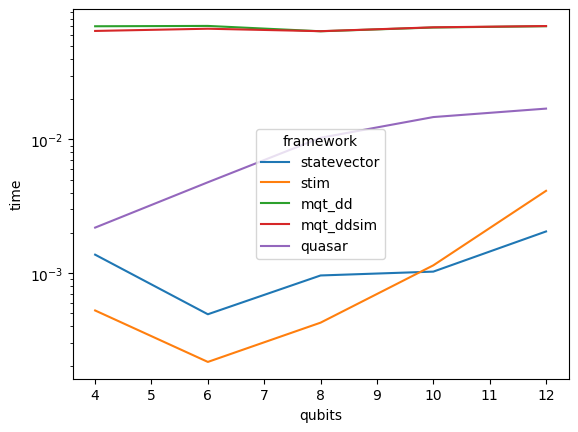

In [1]:
import sys, pathlib
sys.path.append(str(pathlib.Path('..').resolve().parent))
from benchmarks.circuits import graph_state_circuit
from benchmarks.backends import (
    StatevectorAdapter, StimAdapter, MPSAdapter,
    DecisionDiagramAdapter, AerStatevectorAdapter,
    AerMPSAdapter, MQTDDAdapter,
)
from benchmarks.runner import BenchmarkRunner
from quasar import SimulationEngine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

qubit_counts = range(4, 13, 2)
degree = 3

backends = [StatevectorAdapter(), StimAdapter(), MPSAdapter(), DecisionDiagramAdapter()]
for cls in [AerStatevectorAdapter, AerMPSAdapter, MQTDDAdapter]:
    try:
        backends.append(cls())
    except Exception:
        pass

runner = BenchmarkRunner()
engine = SimulationEngine()

for n in qubit_counts:
    circ = graph_state_circuit(n, degree, seed=42)
    plan = engine.planner.plan(circ)
    backend = plan.steps[0].backend.name if plan.steps else None
    print(f"{n} qubits -> {backend}")
    for b in backends:
        try:
            rec = runner.run(circ, b)
            rec['qubits'] = n
            rec['selected_backend'] = None
        except Exception:
            continue
    try:
        rec = runner.run_quasar(circ, engine)
        rec['qubits'] = n
        rec['selected_backend'] = backend
    except Exception:
        runner.results.append({'framework':'quasar','time':float('nan'),'result':None,'qubits':n,'selected_backend':backend})

df = pd.DataFrame(runner.results)
print(df[df['framework']=='quasar'][['qubits','selected_backend']])

sns.lineplot(data=df, x='qubits', y='time', hue='framework')
plt.yscale('log')
plt.show()
